# Practical 7 - Part 1A
The aim of part 1A is to calculate the homography that best maps two sets of points to one another.  We will (eventually) use this for creating panoramas, and for calculating the 3D pose of planes.  You should use this
template for your code and fill in the missing sections marked "TO DO"


# Import libraries 

In [1]:
%matplotlib inline
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

# Define a set of 2D points, then apply a homography to them

In [2]:
# Define a set of two-dimensional Cartesian points
pts1Cart = np.array([[240.5000, 16.8351, 33.5890, 164.2696, 149.1911],
                    [248.8770, 193.5890, 251.3901, 168.4581, 228.7723]])

# Convert points into homogeneous representation
pts1Hom = np.concatenate((pts1Cart, np.ones((1,pts1Cart.shape[1]))), axis=0)

# Define a homography
H = np.array([[0.6, 0.7, -100.],
              [1.0, 0.6, 50.],
              [0.001, 0.002, 1.0]])

# Apply a homography to the points
pts2Hom = np.matmul(H,pts1Hom)

# Convert back to Cartesian coordinates
pts2Cart = pts2Hom[0:2,:] / np.tile([pts2Hom[2,:]],(2,1))

# Add a small amount of noise
noiseLevel = 4.0
pts2Cart = pts2Cart + np.random.normal(0, noiseLevel, pts2Cart.shape)

# Plot the first (original) and  second (after applying the homography) set of points 

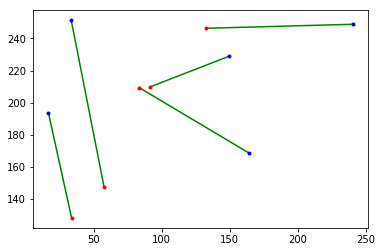

In [3]:
# Plot a green line between pairs of actual points (red) and estimated points (magenta)
nPoint = pts1Cart.shape[1]
for cPoint in range(0, nPoint):
    plt.plot([pts1Cart[0,cPoint], pts2Cart[0,cPoint]], [pts1Cart[1,cPoint], pts2Cart[1,cPoint]],'g-')
    plt.plot(pts1Cart[0,cPoint],pts1Cart[1,cPoint],'b.', pts2Cart[0,cPoint],pts2Cart[1,cPoint],'r.') 

plt.show()

## Comments
The red points are the corresponding results of projective transformation on defined Cartesian points which are labeled to blue. 
The green line shows the mapping from one point to the corresponding point. 
Furthermore, the mapping is done by multiplying the Homography matrix to the homogeneous representation of Cartesian points. Then the resulting homogeneous points are transformed back to Cartesian points. 

Now our goal is to estimate the homography that maps the first points to the second set of points.

# ****TO DO****: Fill in the details of these routines (solveAXEqualsZero and calcBestHomography). 

In [4]:
def solveAXEqualsZero(A):
    # TO DO: Write this routine - it should solve Ah = 0   
    #Compute SVD of matrix A
    u, s, vh = np.linalg.svd(A)
    #set h to the last column of V
    h = vh.T[:,-1]
    return h

In [5]:
# This function should apply the direct linear transform (DLT) algorithm to calculate the best 
# homography that maps the points in pts1Cart to their corresonding matching in pts2Cart
def calcBestHomography(pts1Cart, pts2Cart):    
    # TO DO: replace this
    H = np.zeros([3,3])

    # TO DO: 
    # First convert points into homogeneous representation
    pts1Hom = np.concatenate((pts1Cart, np.ones((1,pts1Cart.shape[1]))), axis=0)
    # Then construct the matrix A, size (n_points,9)  
    #map from 2D -> 2D
    n_points = pts1Cart.shape[1]
    A = np.zeros([2*n_points,9])

    #find the matrix relates to X
    #pts2Cart - dxn
    # value of x in the second coordinate system
    coord2_X = np.tile(pts2Cart[0,:],(3,1)).T
    # value of y in the second coordinate system
    coord2_Y = np.tile(pts2Cart[1,:],(3,1)).T
    
    #concentrate the matrix
    X = np.hstack((pts1Hom.T,np.zeros([n_points,3]),(coord2_X*(-pts1Hom.T))))
    Y = np.hstack((np.zeros([n_points,3]),-pts1Hom.T,(coord2_Y*(pts1Hom.T))))
    
    for i in range(n_points):
        indexRelates_y = 2*i
        indexRelates_x = 2*i + 1
        A[indexRelates_x] = X[i]
        A[indexRelates_y] = Y[i]

    # Solve Ah = 0
    h = solveAXEqualsZero(A)
    # Reshape h into the matrix H, values of h go first into rows of H
    H = np.reshape(h,H.shape)
    return H

Once you have completed the two routines above, we will see how well they work by applying the mapping and measuring the square distance between the desired and actual positions

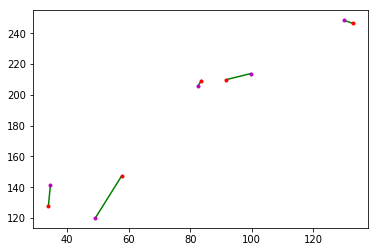

In [6]:
# TO DO: Fill in the details of this function from above 
HEst = calcBestHomography(pts1Cart, pts2Cart)

# Apply estimated homography to points
pts2EstHom = np.matmul(HEst,pts1Hom)

# Convert back to Cartesian coordinates
pts2EstCart = pts2EstHom[0:2,:] / np.tile([pts2EstHom[2,:]],(2,1))

# Calculate the mean squared distance from actual points
sqDiff = np.mean(sum((pts2Cart - pts2EstCart)**2))

# Draw figure with points before and after applying the estimated homography
nPoint = pts1Cart.shape[1]

# Plot a green line between pairs of actual points (red) and estimated points (magenta)
for cPoint in range(0, nPoint):
    plt.plot([pts2Cart[0,cPoint], pts2EstCart[0,cPoint]], [pts2Cart[1,cPoint], pts2EstCart[1,cPoint]],'g-')
    plt.plot(pts2Cart[0,cPoint],pts2Cart[1,cPoint],'r.',pts2EstCart[0,cPoint],pts2EstCart[1,cPoint],'m.') 

plt.show()

## Comments
The Homography matrix that maps one set of points in one coordinate system to another set of points which are in another coordinate system is required to be found. The purple points are the estimated points of red points. The green line shows the distance between the estimated point and the ground truth point. The program find the best estimated Homography matrix by solving the equation of Ah = 0. The equation Ah=0 describes the transformation between the two sets of points. However,due to the added random noise, the estimated point may be not able to be recovered exactly. Here,only four pairs of points are used to find the best Homography matrix. However, more points may be required for more precise estimation when there is random noise.



# Other things **** TO DO ****

1: Convince yourself that the homography is ambiguous up to scale (by
multiplying it by a constant factor and showing it does the same thing).
Can you see why this is the case mathematically?

2: Show empirically that your homography routine can map any four points exactly to any
other four points

 ## Q1
 Adding a scale factor $\lambda$ will not cause big change to the result.
 
 $\lambda' \begin{bmatrix}
        x\\ 
        y\\ 
        1
       \end{bmatrix}
       = \lambda
       \begin{bmatrix}
       \phi_{11} & \phi_{12} & \phi_{13}\\ 
       \phi_{21} & \phi_{22} & \phi_{23}\\ 
       \phi_{31} & \phi_{32} & \phi_{33}
       \end{bmatrix}
       \begin{bmatrix}
        u\\ 
        v\\ 
        1
       \end{bmatrix}$
 
 We have
 
 $x=\frac{\lambda(\phi_{11}u+\phi_{12}v+\phi_{13})}{\lambda(\phi_{31}u+\phi_{32}v+\phi_{33})}$
 
 $ y=\frac{\lambda(\phi_{21}u+\phi_{22}v+\phi_{23})}{\lambda(\phi_{31}u+\phi_{32}v+\phi_{33})}$
 
 The calculation is not sensitive to the scale because we need to eluminate the scale factor when we transform Homogeneous coordinates to Cartesian coordinates.

## Q2
With only four points, the Homography routine can still map the points to correct location.
The Homography matrix may be changed by multiplying by an non-zero scale factor without changing the projective transformation.  Therefore, the Homography matrix is a Homogeneous matrix.  In the Homogeneous representation of points, we only care about the ratio of the matrix elements. There are eight independent ratios in the Homography matrix. Then, the homography matrix has in fact 8 unknowns, which means we need a minimum of four pairs of points to build up a set of equations.